In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import torch
import sklearn.cluster as sl
import matplotlib.pyplot as plt

In [2]:
def sqrtinvdiag(M):
    """Inverts and square-roots a positive diagonal matrix.
    Args:
        M (csc matrix): matrix to invert
    Returns:
        scipy sparse matrix of inverted square-root of diagonal
    """

    d = M.diagonal()
    dd = [1 / max(np.sqrt(x), 1 / 999999999) for x in d]

    return sp.dia_matrix((dd, [0]), shape=(len(d), len(d))).tocsc()

2009
[ 0  1  2  6  8 12  3  5 13 11  9  4 10  7]
[0.19806917 0.17749188 0.06375921 0.03026869 0.00793216 0.0233774
 0.06274592 0.00359421 0.04218583 0.01160565 0.00438755 0.01269124
 0.03129383 0.01695779]


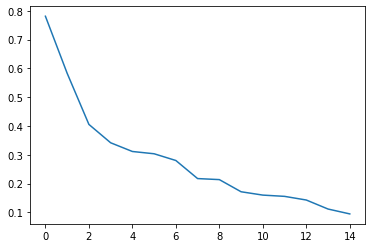

2010
[ 1  9  2  7  0  4  3 11 10  5  8  6 13 12]
[0.04221125 0.08481357 0.06047355 0.03142831 0.03355956 0.01616679
 0.01300877 0.0583654  0.01465839 0.07682013 0.0176084  0.02872598
 0.00718069 0.01272388]


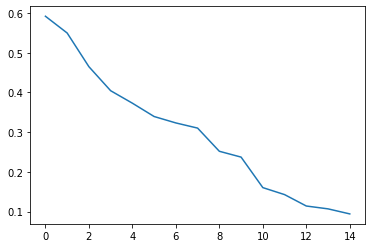

2011
[ 1  0  9  3  8  7  2 12  6 11 10 13  5  4]
[0.1250489  0.16215792 0.02134662 0.06170641 0.00547257 0.0079058
 0.01698848 0.02397953 0.04077562 0.06963682 0.01161922 0.01178004
 0.01974668 0.01157555]


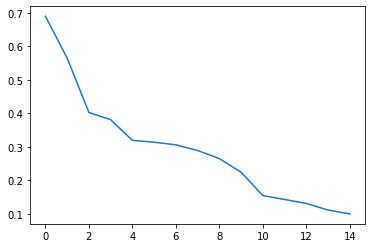

2012
[ 1  0  9  2  3 13  5  4  8 11 10  6  7 12]
[0.07642219 0.17269284 0.03408562 0.03391598 0.02964122 0.03028463
 0.0230158  0.02020041 0.02675689 0.05509802 0.02475776 0.02534678
 0.01496951 0.03076675]


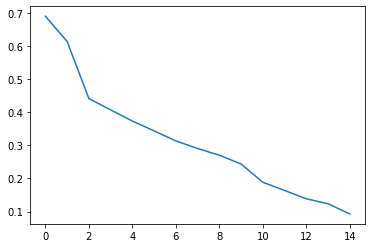

2013
[ 1  0 13  5  4  6  2 11 10 12  9  7  3  8]
[0.0918174  0.2696775  0.02111018 0.01175608 0.02917258 0.03324867
 0.02383211 0.01406264 0.00433057 0.01582763 0.01962053 0.0210363
 0.01649459 0.05033803]


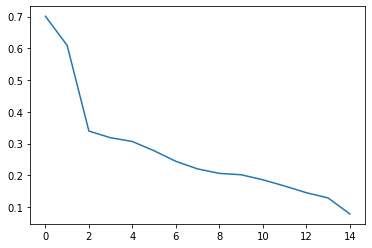

2014
[ 2  6  3  1  9 13  0  5  7  8 11  4 10 12]
[0.03753741 0.04671056 0.08210621 0.05687401 0.01278953 0.0351044
 0.07962705 0.03196554 0.02920287 0.04274651 0.01195529 0.02433516
 0.01123258 0.04060764]


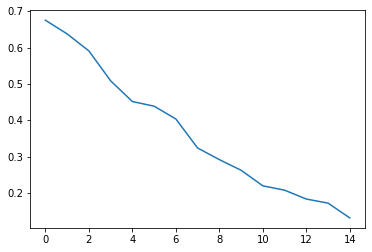

In [3]:
for season in range(2009, 2015):
    adj = sp.load_npz('./England_'+str(season)+'_'+str(season+1)+'adj.npz')
    A = adj.tocsc()
    D_out = sp.diags(A.transpose().sum(
        axis=0).tolist(), [0]).tocsc()
    D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
    Dbar = (D_in + D_out)
    d = sqrtinvdiag(Dbar)
    normA = d * A * d
    size = A.shape[0]
    H = (A-A.transpose()) * 1j
    H_abs = np.abs(H)
    D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
    D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
    H_rw = D_abs_inv.dot(H)
    _, s, _ = sp.linalg.svds(H_rw, 15)
    eigens = s[list(np.arange(14,-1,-1))]
    eigengaps = eigens[:-1] - eigens[1:]
    print(season)
    print(np.argsort(-eigengaps))
    print(eigengaps)
    plt.plot(eigens)
    plt.show()
    # choose K = 9

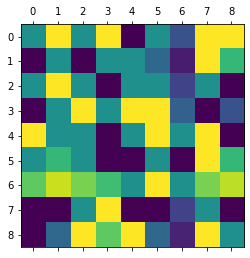

19

In [4]:
num_clusters = 9
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)